# 1 - Configuring the Data for our Model


## Import Python Packages

You will first need to import the following Python packages:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

The following packages will be needed from the Azure ML Python SDK:

In [2]:
import azureml.core
from azureml.core import Workspace
from azureml.core import Dataset
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.opendatasets import MNIST
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.33.0


## Workspace

If you are running this notebook as a part of your Azure Machine Learning Studio workspace, you can get a reference to your workspace by simply running the following code:

In [3]:
ws = Workspace.from_config()
print("Azure ML Workspace")
print(f'Name: {ws.name}')
print(f'Location: {ws.location}')
print(f'Resource Group: {ws.resource_group}')

Azure ML Workspace
Name: carlartest
Location: westeurope
Resource Group: networkwatcherrg


## Provisioning Compute Resources

We will include the logic from the previous module around provisioning compute resources.  This will create a cluster of Standard NC6 instances that can scale from 0 to 4 nodes.

In [4]:
# Create a name for our new cluster
cpu_cluster_name = 'Std-V2-Cluster'

# Verify that cluster does not exist already
try:
    cpu_cluster = AmlCompute(workspace=ws, name=cpu_cluster_name)
    print('Cluster already exists.')
    
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                           max_nodes=4)
    cpu_cluster = AmlCompute.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

InProgress....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


We can use the `get_status()` method on the `cpu_cluster` instance to get the details on our compute cluster.

In [5]:
status = cpu_cluster.get_status()
print(f'Nodes: {str(status.current_node_count)}')
print(f'VM Size: {str(status.vm_size)}')
print(f'Provsioning State: {str(status.provisioning_state)}')
print(f'Scale Settings: {str(status.scale_settings.serialize())}')

Nodes: 0
VM Size: STANDARD_NC6
Provsioning State: Succeeded
Scale Settings: {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}


For more information around GPU VM instances, view the following link:
    
* [GPU optimized virtual machine sizes](https://docs.microsoft.com/en-us/azure/virtual-machines/windows/sizes-gpu)

## Data Set

We first need to setup the directory that will store our data set:

In [6]:
data_folder = os.path.join(os.getcwd(), 'data')
print(f'Data folder: {data_folder}')
os.makedirs(data_folder, exist_ok=True)

Data folder: /mnt/batch/tasks/shared/LS_root/mounts/clusters/carlartest/code/Users/fiabebe/CutieTest/data


Next, we will use the open dataset for MNIST that exists within the Azure ML Python SDK.  We will get a reference to the data set, and then we will download the data into the directory that we just created:

In [7]:
mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/carlartest/code/Users/fiabebe/CutieTest/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/carlartest/code/Users/fiabebe/CutieTest/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/carlartest/code/Users/fiabebe/CutieTest/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/carlartest/code/Users/fiabebe/CutieTest/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

## Exploring the Data

To be able to load and visualize the data, we will be leverage methods from two files that are included with this notebook, `utils.py` and `display.py`.

In [8]:
# make sure utils.py is in the same directory as this code
from utils import load_data
from display import find_sample_data
from display import plot_images

Next, we need to load in the train and test data (both images and labels). We will leverage the `load_data` function that is inlcuded from Microsoft in the `utils.py` file:

In [9]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
training_images = load_data(data_folder, "train-images-idx3-ubyte.gz") / 255.0
training_images = np.reshape(training_images, (-1, 28,28))
test_images = load_data(data_folder, "t10k-images-idx3-ubyte.gz") / 255.0
test_images = np.reshape(test_images, (-1, 28,28))

training_labels = load_data(data_folder, "train-labels-idx1-ubyte.gz", True).reshape(-1)
test_labels = load_data(data_folder, "t10k-labels-idx1-ubyte.gz", True).reshape(-1)

print(f'Training Image: {training_images.shape}')
print(f'Training Labels: {training_labels.shape}')
print(f'Test Images: {test_images.shape}')
print(f'Test Labels: {test_labels.shape}')

Training Image: (60000, 28, 28)
Training Labels: (60000,)
Test Images: (10000, 28, 28)
Test Labels: (10000,)


Next, we can visulalize some of the data that we have pulled in.  We can review four examples of each category from the test data using the following code:

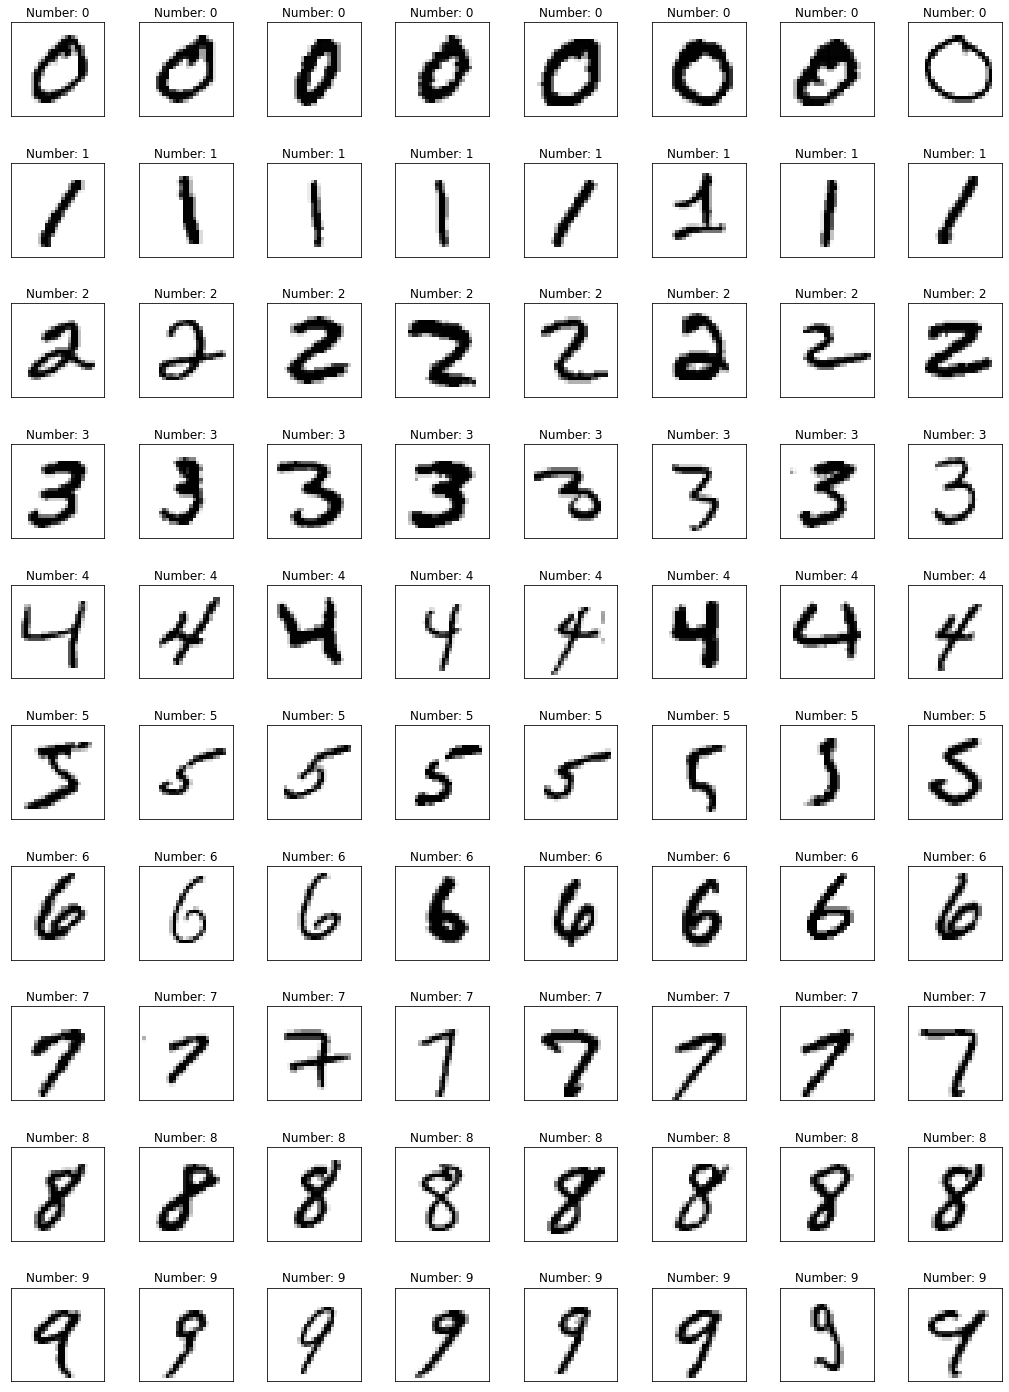

In [10]:
# find exmaples of the data and visualize it
extracted_test_data = find_sample_data(training_images, training_labels, 8, randomize=False)
plot_images(extracted_test_data)